### Uses a modified algorithm class to optimize upper bound for population size

In [ ]:
import optuna
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

### Define the modified algorithm class

In [11]:
# One random number generator for algo
rng = np.random.default_rng(seed=207)

class Algorithm:
    def __init__(self, forecasted_info, policy_optimization_period):
        self.policy_optimization_period = policy_optimization_period
        ### Parameter bound information

        # Num skus based on the forecasted_info dataset
        self.num_skus = len(forecasted_info["Pcode"].unique())
        # Max order frequency is up to the length of the policy_optimization_period
        self.max_order_frequency = policy_optimization_period
        # Upper and lower bounds for both frequency and reorder quantity
        self.parameter_bounds = np.zeros((2*self.num_skus, 2))
        # Get unique SKUs the indices that they map back to
        unique_skus, inverse_indices = np.unique(forecasted_info["Pcode"], return_inverse=True)
        # Create an array for max quantities for each SKU
        max_quantities = np.zeros(len(unique_skus))
        np.maximum.at(max_quantities, inverse_indices, forecasted_info["Quantity Sold"].to_numpy())
        # Set the upper bounds
        self.parameter_bounds[0::2, 1] = max_quantities  # Max quantity sold
        self.parameter_bounds[1::2, 1] = self.max_order_frequency  # Max order frequency

        ### Objective function information

        # Calculate the forecast weeks based on the policy optimization period
        weeks = np.sort(forecasted_info["Week"].unique())
        self.forecast_weeks = weeks[-policy_optimization_period:]

        # Should convert it into the following form:
        self.skus = forecasted_info["Pcode"].unique()

        # Get only the forecast weeks
        forecast_data = forecasted_info[forecasted_info["Week"].isin(self.forecast_weeks)]
        # Calculate prices
        prices = forecasted_info.drop_duplicates(subset="Pcode", keep="first").set_index("Pcode")["Price"].map(lambda x: float(x[1:]))
        self.prices = prices.ravel()
        # Calculate quantities (null values are 0 if exist)
        quantities_df = forecast_data.pivot(index="Pcode", columns="Week", values="Quantity Sold")
        self.quantities = quantities_df.reindex(self.skus).fillna(0).to_numpy()
        
    def run_algorithm(
            self,
            n_generations, 
            missed_sales_importance,
            inventory_space_importance,
            reorder_cost_importance,
            upper_bound
        ):
        """
        Takes in user inputs and performs hyperparameter search + differential evolution
        """
        # Define the objective function for Optuna
        def hyperparamter_search_objective(trial):
            population_size = trial.suggest_int('population_size', 10, upper_bound)
            mutation_factor = trial.suggest_float('mutation_factor', 0.1, 2.0)
            p_crossover = trial.suggest_float('p_crossover', 0.1, 0.9)
                
            # Call your differential evolution function with the suggested hyperparameters
            _, score = self.differential_evolution(
                    objective_function=self.f,
                    parameter_bounds=self.parameter_bounds,
                    population_size=int(population_size),
                    n_generations=200,
                    mutation_factor=mutation_factor,
                    p_crossover=p_crossover,
                    quantities=self.quantities,
                    prices=self.prices,
                    policy_optimization_period=self.policy_optimization_period,
                    num_skus=self.num_skus,
                    a=missed_sales_importance,
                    b=inventory_space_importance,
                    c=reorder_cost_importance
            )
            return score  # The goal is to minimize this score

        # Create an Optuna study
        study = optuna.create_study(direction='minimize') 

        # Optimize the objective function
        n_trials = 100
        study.optimize(hyperparamter_search_objective, n_trials=n_trials) 

        # Extract best hyperparameters
        best_hyperparameters = study.best_params

        return study.best_value

    def initialize_population(self, bounds, population_size):
        bounds = np.array(bounds, dtype=np.float64)  # Convert bounds to a NumPy array
        lower_bounds = bounds[:, 0]
        upper_bounds = bounds[:, 1]
        population = rng.uniform(lower_bounds, upper_bounds, (population_size, len(bounds)))
        return population

    def differential_evolution(self,
        objective_function, parameter_bounds, population_size, n_generations, mutation_factor, p_crossover,
        quantities, prices, policy_optimization_period, num_skus, a, b, c
    ):
        # Initialize population and current fitnesses
        population = self.initialize_population(self.parameter_bounds, population_size)
        fitness = np.array([
            objective_function(ind, quantities, prices, policy_optimization_period, num_skus, a, b, c)
            for ind in population
        ])

        bounds_array = np.array(parameter_bounds)
        lower_bounds, upper_bounds = bounds_array[:, 0], bounds_array[:, 1]

        for _ in range(n_generations):
            # Mutation and crossover in a vectorized manner
            indices = np.arange(population_size)
            a_indices = rng.choice(indices, size=population_size, replace=True)
            b_indices = rng.choice(indices, size=population_size, replace=True)
            c_indices = rng.choice(indices, size=population_size, replace=True)

            # Ensure indices are not equal to the current individual
            valid = a_indices != indices
            a_indices[~valid] = (a_indices[~valid] + 1) % population_size

            # Calculate mutants
            a1, b1, c1 = population[a_indices], population[b_indices], population[c_indices]
            mutants = a1 + mutation_factor * (b1 - c1)
            mutants = np.clip(mutants, lower_bounds, upper_bounds)

            # Ensure reorder amounts and frequencies are integers
            mutants = np.round(mutants)

            # Perform crossover
            crossover_mask = rng.random((population_size, len(parameter_bounds))) < p_crossover
            trial_population = np.where(crossover_mask, mutants, population)
            # Evaluate the new population
            trial_fitness = np.array([
                objective_function(ind, quantities, prices, policy_optimization_period, num_skus, a, b, c)
                for ind in trial_population
            ])

            # Update population and fitness using a loop
            for i in range(population_size):
                if trial_fitness[i] < fitness[i]:
                    population[i] = trial_population[i]
                    fitness[i] = trial_fitness[i]

        best_index = np.argmin(fitness)  # Minimize the objective
        return population[best_index], fitness[best_index]

    def f(self, individual, quantities, prices, policy_optimization_period, num_skus, a, b, c):
        # Extract reorder quantities and frequencies from the individual
        reorder_quantities = np.array(individual[0::2], dtype=int)
        reorder_frequencies = np.array(individual[1::2], dtype=int)

        # Initialize SKU quantities and costs
        sku_quantities = np.zeros((policy_optimization_period, num_skus), dtype=np.float64)
        missed_sales = np.zeros(num_skus, dtype=np.float64)
        inventory = np.zeros(policy_optimization_period, dtype=np.float64)
        reorder_cost = np.zeros(num_skus, dtype=np.float64)

        # Create a matrix of time steps
        time_steps = np.arange(1, policy_optimization_period + 1).reshape(-1, 1)

        # If any frequency becomes negative, don't ever restock
        # Otherwise calculate when each restock happens
        adjusted_frequencies = np.where(reorder_frequencies > 0, reorder_frequencies, np.inf)
        restock_mask = (time_steps % adjusted_frequencies) == 0
        restock_mask = np.where(adjusted_frequencies == np.inf, False, restock_mask)

        # Calculate reorder amounts
        reorder_amounts = restock_mask * reorder_quantities
        sku_quantities += np.cumsum(reorder_amounts, axis=0)

        # Subtract demand week by week
        demand_matrix = quantities.T
        sku_quantities -= demand_matrix

        # Calculate missed sales where stock is negative
        missed_stock = np.minimum(sku_quantities, 0)
        missed_sales += np.sum(-missed_stock * prices, axis=0)
        sku_quantities = np.maximum(sku_quantities, 0)

        # Calculate reorder costs
        reorder_cost += np.sum(restock_mask, axis=0)
        # Calculate inventory cost as total stock across all weeks
        inventory += np.sum(sku_quantities, axis=1)

        # Readjust weights and calculate the total cost
        total_cost = (a * np.sum(missed_sales, dtype=np.float64)) + (b * np.sum(inventory, dtype=np.float64)) + (c  * np.sum(reorder_cost, dtype=np.float64))
        return total_cost

### Create user input

In [6]:
forecasted_info = pd.read_csv("ForecastedInformation.csv")

# Policy optimization period period- how far in advance we want to forecast the skus
policy_optimization_period = 5
# Weights for missed sales, inventory space, and reorder cost
missed_sales_importance = 1
inventory_space_importance = 1
reorder_cost_importance = 1
# User will input this- it's equivalent to giving a time budget for the algorithm
n_generations = 10000

### Run experiments on 7 different upper bounds for population size

In [12]:
algo_runner = Algorithm(forecasted_info, policy_optimization_period)
bounds = [20, 30, 40, 50, 60, 70, 80]
scores = []
times = []
for upper_bound in bounds:
    start = time.time()
    scores.append(algo_runner.run_algorithm(n_generations, missed_sales_importance, inventory_space_importance, reorder_cost_importance, upper_bound))
    end = time.time()
    times.append(float(end - start))

/var/folders/hh/rn_fsj015zz6cmlmssx4w0y00000gn/T/ipykernel_68330/597132708.py:41: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  self.prices = prices.ravel()
[I 2024-12-01 20:16:22,802] A new study created in memory with name: no-name-e5acdfda-ee5d-44e4-8b15-c59bfd5ee7ea
[I 2024-12-01 20:16:23,172] Trial 0 finished with value: 16660430.848979978 and parameters: {'population_size': 16, 'mutation_factor': 1.4499688489779616, 'p_crossover': 0.14523269153059362}. Best is trial 0 with value: 16660430.848979978.
[I 2024-12-01 20:16:23,600] Trial 1 finished with value: 11471016.742067514 and parameters: {'population_size': 18, 'mutation_factor': 0.8563485837607037, 'p_crossover': 0.39248897822509365}. Best is trial 1 with value: 11471016.742067514.
[I 2024-12-01 20:16:24,047] Trial 2 finished with value: 16275374.987399803 and parameters: {'population_size': 20, 'mutation_fa

### Plot the times and scores for each bound

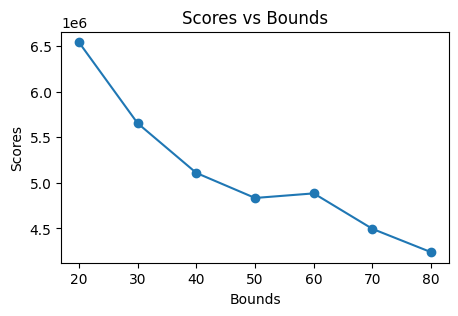

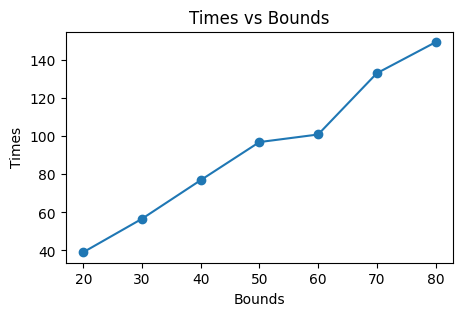

In [17]:
# Plot Scores
plt.figure(figsize=(5, 3))
plt.plot(bounds, scores, label='Scores', marker='o')
plt.xlabel('Bounds')
plt.ylabel('Scores')
plt.title('Scores vs Bounds')
plt.show()

# Plot Times
plt.figure(figsize=(5, 3))
plt.plot(bounds, times, label='Times', marker='o')
plt.xlabel('Bounds')
plt.ylabel('Times')
plt.title('Times vs Bounds')
plt.show()